# Example models including higher order kinematic components #

**Each model considered here includes the following components:**

 - Disk + Bulge
 - NFW halo
 - Constant velocity dispersion
 
And, for the non-fiducial cases: 
 - A non-circular, higher-order kinematic component

## Setup steps ##

**Import modules**

In [1]:
from __future__ import (absolute_import, division, print_function, unicode_literals)

import copy
import numpy as np
import astropy.units as u
import astropy.io.fits as fits

from dysmalpy import galaxy, models, instrument, data_classes, \
                     parameters, observation, plotting


**Setup notebook**

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)

**Import functions to tie scale height relative to effective radius, 
and the halo mass to the $\boldsymbol{f_{DM}}$ value**

In [3]:
from dysmalpy.fitting_wrappers.tied_functions import tie_sigz_reff, tie_lmvirial_to_fdm

**Specify some settings for the plot contours**

In [4]:
kwargs_contour = {'lw_cont': 0.75, 
                  'delta_cont_v': 50., 
                  'delta_cont_disp': 25., 
                  'delta_cont_flux': 50., 
                  'delta_cont_v_minor': 10., 
                  'delta_cont_disp_minor': 5.,
                  'delta_cont_flux_minor': 10., 
                  'lw_cont_minor': 0.2, 
                  'colors_cont_minor': 'black',
                  'delta_cont_flux_minor_resid': 0.2,
                  'delta_cont_disp_minor_resid': 1.,
                  'lw_cont_minor_resid': 0.15, 
                  'ls_cont_minor_resid': ':', 
                  'colors_cont_minor_resid': 'grey', 
                  'max_residual': 100.} 

---------

<font size="4">**Script to help with creating galaxy instances**</font>

In [5]:
def make_gal(name=None, hiord=None):
    gal = galaxy.Galaxy(z=z, name=name)
    mod_set = models.ModelSet()
    
    obs = observation.Observation(name='mock', tracer='line')
    obs.fit_options.fit_flux = True
    obs.mod_options.oversample = 3
    
    ### Add all model components to ModelSet
    mod_set.add_component(copy.deepcopy(bary), light=True)
    mod_set.add_component(copy.deepcopy(halo))
    mod_set.add_component(copy.deepcopy(disp_prof))
    mod_set.add_component(copy.deepcopy(zheight_prof))
    mod_set.add_component(copy.deepcopy(geom))
    if hiord is not None:
        mod_set.add_component(copy.deepcopy(hiord), light=False)

    ### Set kinematic options for calculating velocity profile
    mod_set.kinematic_options.adiabatic_contract = False
    mod_set.kinematic_options.pressure_support = True

    ### Add the model set, instrument to the Galaxy / observation
    gal.model = copy.deepcopy(mod_set)
    
    obs.instrument = copy.deepcopy(inst)
    gal.add_observation(obs)
    
    return gal

---------

## Fiducial model ##

In [6]:
# Redshift:
z = 2.

<font size="4">**Baryonic component: Combined Disk+Bulge**</font>

In [7]:
total_mass = 10.5    # M_sun
bt = 0.3             # Bulge-Total ratio
r_eff_disk = 4.0     # kpc
n_disk = 1.0
invq_disk = 5.0
r_eff_bulge = 1.0    # kpc
n_bulge = 4.0
invq_bulge = 1.0
noord_flat = True    # Switch for applying Noordermeer flattening

# Fix components
bary_fixed = {'total_mass': False,
              'r_eff_disk': False,
              'n_disk': True,
              'r_eff_bulge': True,
              'n_bulge': True,
              'bt': False}

# Set bounds
bary_bounds = {'total_mass': (10, 13),
               'r_eff_disk': (1.0, 30.0),
               'n_disk': (1, 8),
               'r_eff_bulge': (1, 5),
               'n_bulge': (1, 8),
               'bt': (0, 1)}

bary = models.DiskBulge(total_mass=total_mass, bt=bt,
                        r_eff_disk=r_eff_disk, n_disk=n_disk,
                        invq_disk=invq_disk,
                        r_eff_bulge=r_eff_bulge, n_bulge=n_bulge,
                        invq_bulge=invq_bulge,
                        noord_flat=noord_flat,
                        name='disk+bulge',
                        fixed=bary_fixed, bounds=bary_bounds)

bary.r_eff_disk.prior = parameters.BoundedGaussianPrior(center=5.0, stddev=1.0)

<font size="4">**Halo component**</font>

In [8]:
mvirial = -99
conc = 5.0
fdm = 0.5

halo_fixed = {'mvirial': False,
              'conc': True, 
              'fdm': False}

halo_bounds = {'mvirial': (10, 13),
               'conc': (1, 20),
               'fdm': (0, 1)}

halo = models.NFW(mvirial=mvirial, conc=conc, fdm=fdm, z=z,
                  fixed=halo_fixed, bounds=halo_bounds, name='halo')
halo.mvirial.tied = tie_lmvirial_to_fdm
# The tied component must have "fixed=False", and then a specified tied function 

<font size="4">**Dispersion profile**</font>

In [9]:
sigma0 = 39.   # km/s
disp_fixed = {'sigma0': False}
disp_bounds = {'sigma0': (5, 300)}

disp_prof = models.DispersionConst(sigma0=sigma0, fixed=disp_fixed,
                                   bounds=disp_bounds, name='dispprof',
                                   tracer='line')

<font size="4">**Light z-height profile**</font>

In [10]:
sigmaz = 0.9   # kpc
zheight_fixed = {'sigmaz': False}

zheight_prof = models.ZHeightGauss(sigmaz=sigmaz, name='zheightgaus',
                                   fixed=zheight_fixed)
zheight_prof.sigmaz.tied = tie_sigz_reff
# The tied component must have "fixed=False", and then a specified tied function

<font size="4">**Geometry**</font>

In [11]:
inc = 62.     # degrees
pa = 142.     # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center

geom_fixed = {'inc': False,
              'pa': True,
              'xshift': True,
              'yshift': True}

geom_bounds = {'inc': (0, 90),
               'pa': (90, 180),
               'xshift': (0, 4),
               'yshift': (-10, -4)}

geom = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift,
                       fixed=geom_fixed, bounds=geom_bounds, name='geom',
                       obs_name='mock')

<font size="4">**Set up the instrument**</font>

In [12]:
inst = instrument.Instrument()

inst.ndim = 2

beamsize = 0.55*u.arcsec                 # FWHM of beam
sig_inst = 45*u.km/u.s                   # Instrumental spectral resolution

beam = instrument.GaussianBeam(major=beamsize)
lsf = instrument.LSF(sig_inst)

inst.beam = beam
inst.lsf = lsf
inst.pixscale = 0.125*u.arcsec           # arcsec/pixel
inst.fov = [33, 33]                      # (nx, ny) pixels
inst.spec_type = 'velocity'              # 'velocity' or 'wavelength'
inst.spec_step = 10*u.km/u.s             # Spectral step
inst.spec_start = -1000*u.km/u.s         # Starting value of spectrum
inst.nspec = 201                         # Number of spectral pixels

# Set the beam kernel so it doesn't have to be calculated every step
inst.set_beam_kernel()
inst.set_lsf_kernel()

<font size="4">**Setup the galaxy and model set**</font>

In [13]:
gal = make_gal(name='galaxy')

<font size="4">**Create 2D model**</font>

In [14]:
gal.create_model_data()

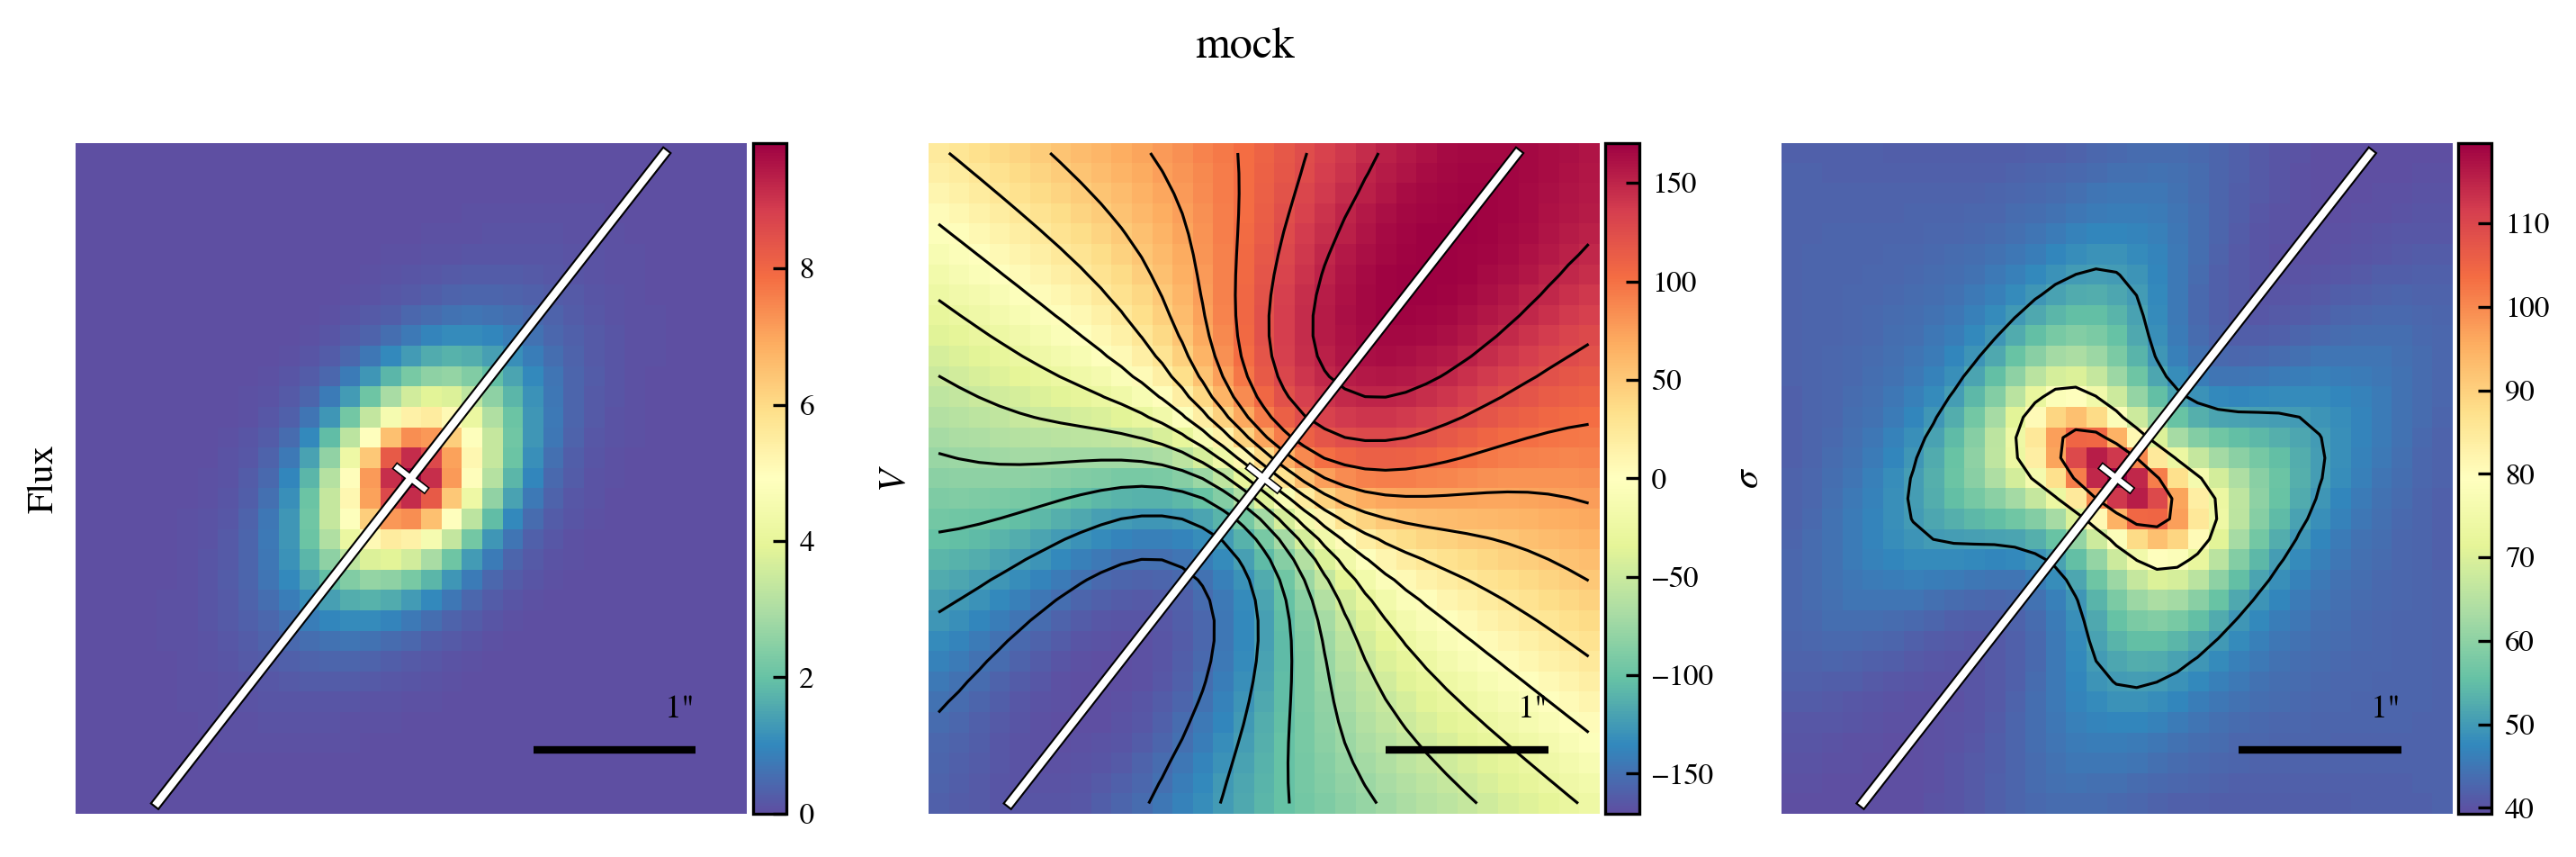

In [15]:
plotting.plot_model_2D(gal, inst_corr=True, ruler_loc='lowerright')

---------

## Example 1: Uniform planar inflow ##



<font size="4">**Define the higher-order kinematic component**</font>

In [16]:
vr = -90.

uniform_planar_inflow = models.PlanarUniformRadialFlow(vr=vr, 
                             name='uniform_planar_inflow')

<font size="4">**Setup the galaxy and model set**</font>

In [17]:
gal_planar_inflow = make_gal(name='galaxy_planar_uniform_inflow', 
                             hiord=uniform_planar_inflow)

<font size="4">**Create 2D model and compare to fiducial**</font>

In [18]:
gal_planar_inflow.create_model_data()

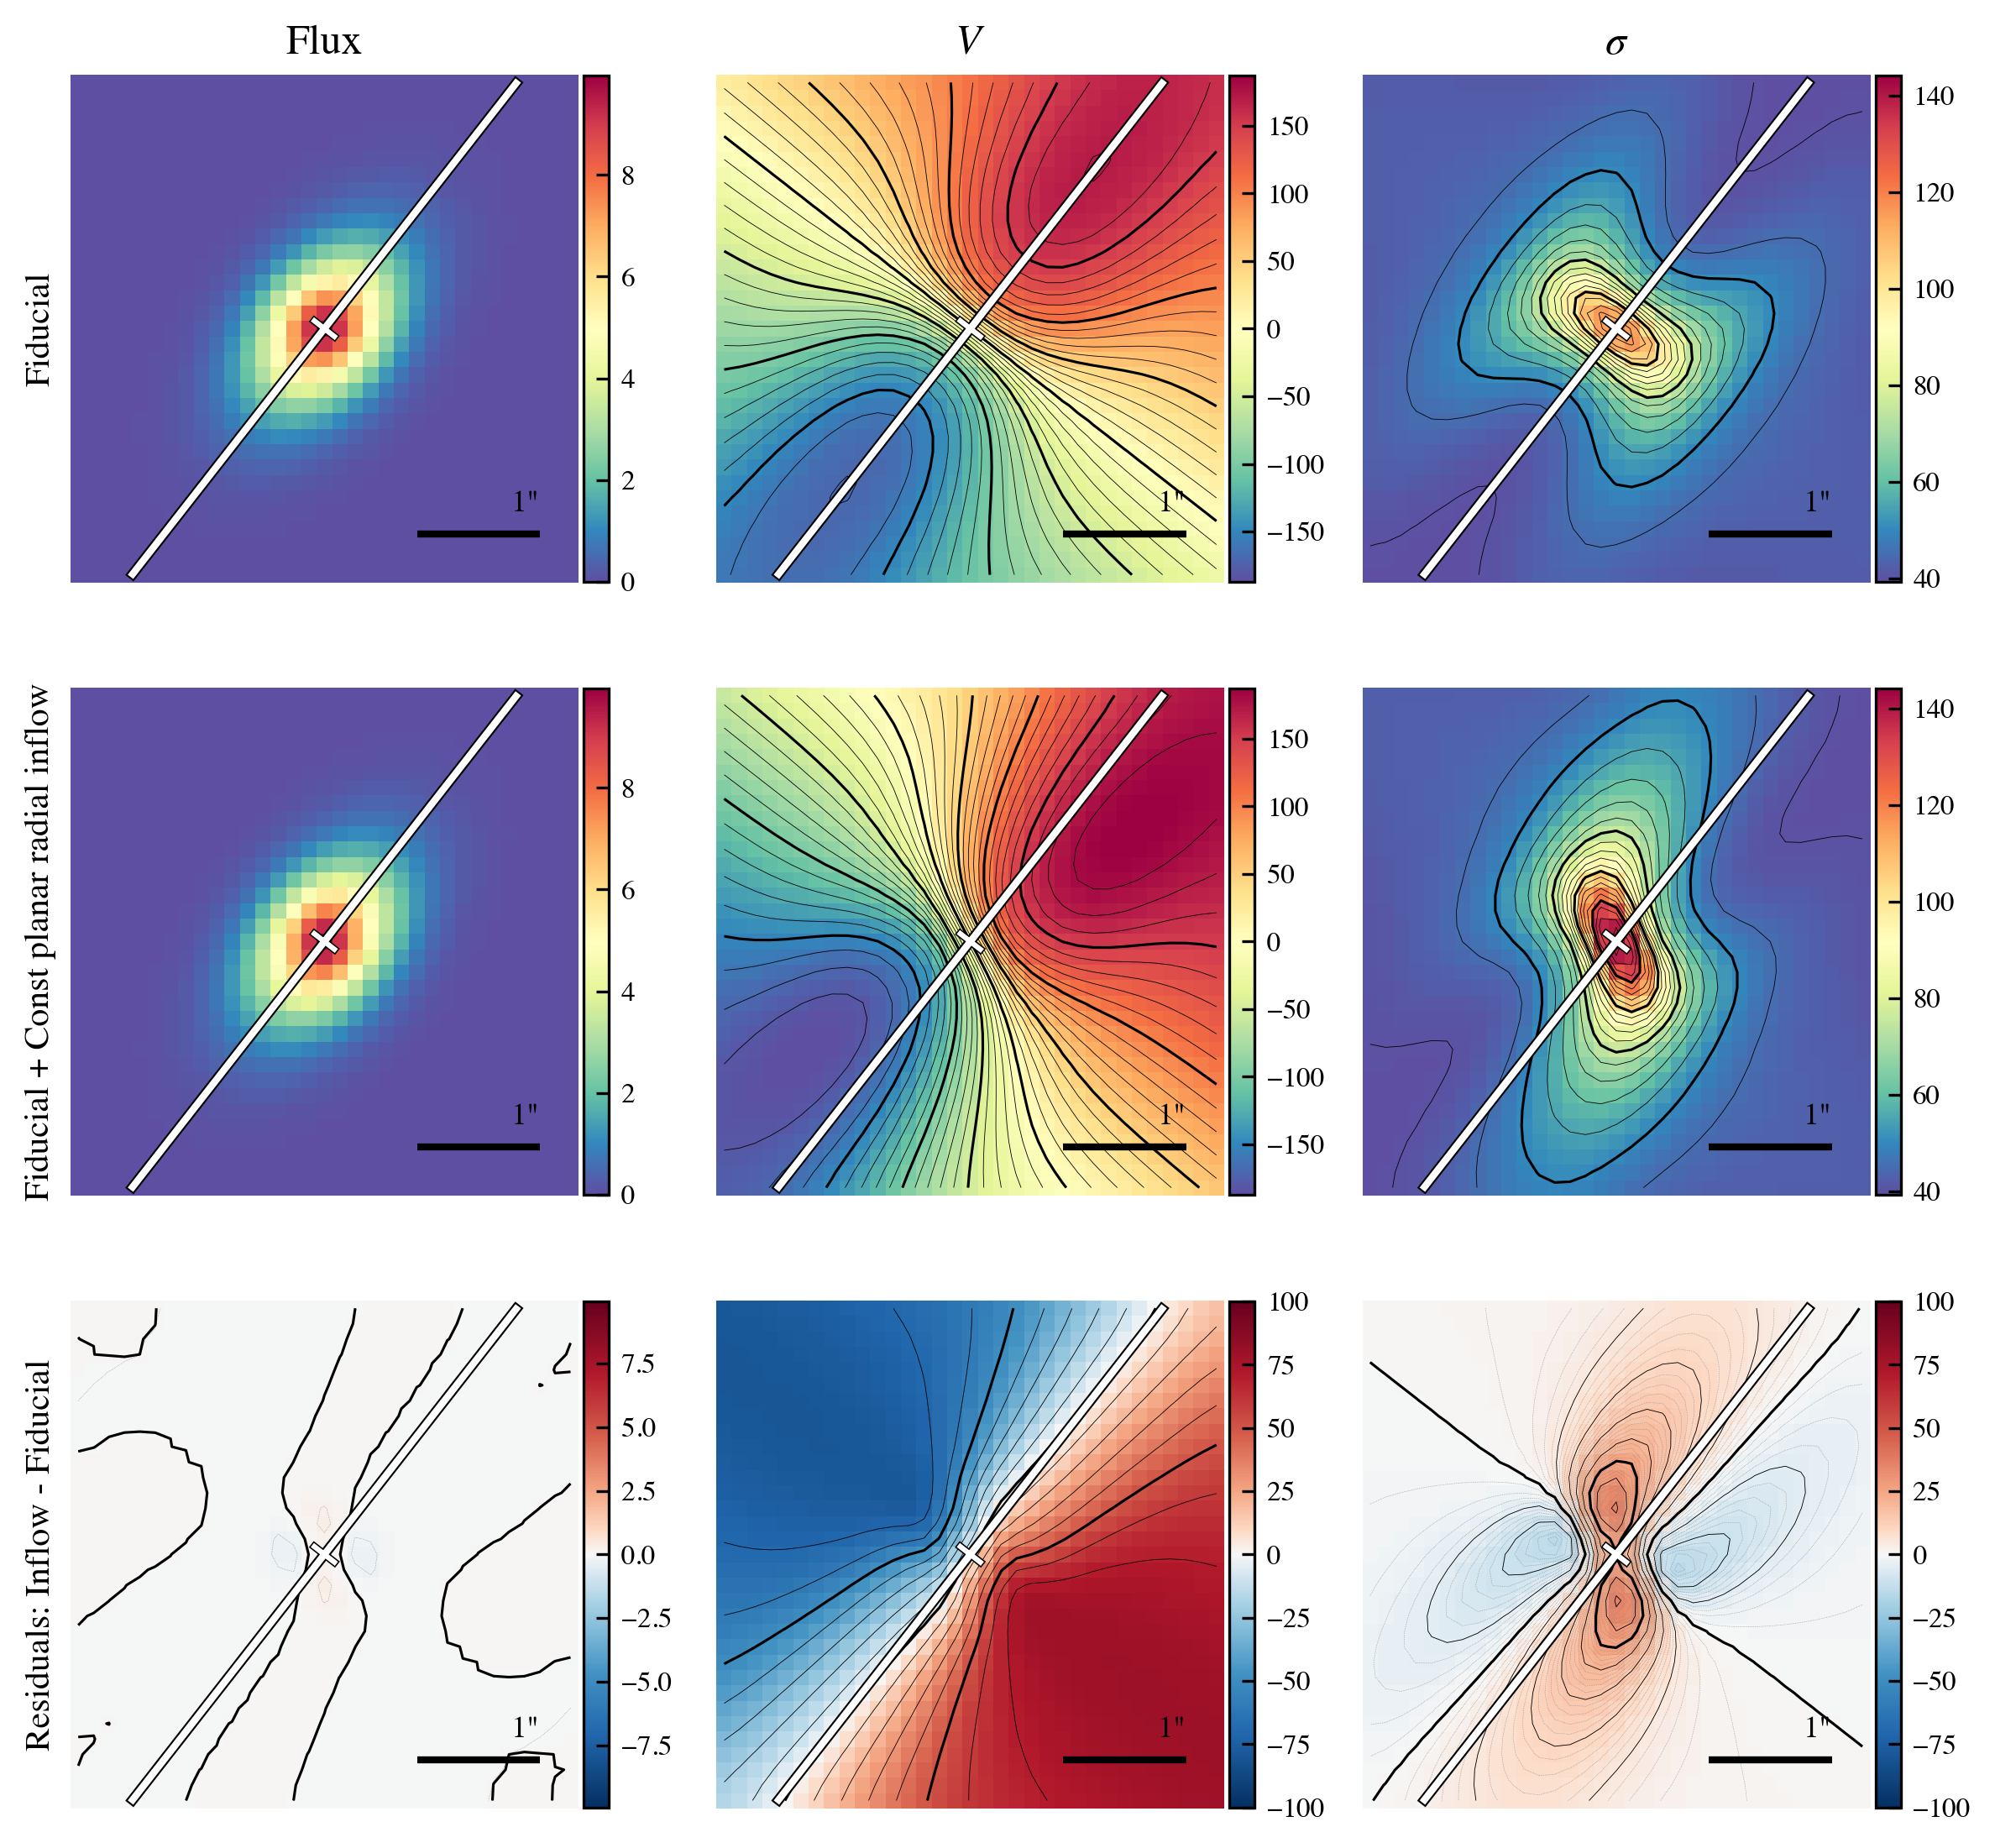

In [19]:
plotting.plot_model_comparison_2D(obs1=gal.observations['mock'], 
                                  obs2=gal_planar_inflow.observations['mock'], 
                                  model1=gal.model, model2=gal_planar_inflow.model, 
                                  label_gal1='Fiducial', 
                                  label_gal2='Fiducial + Const planar radial inflow', 
                                  label_residuals='Residuals: Inflow - Fiducial', 
                                  show_contours=True, **kwargs_contour)

---------

## Example 2: Uniform bar inflow ##

<font size="4">**Define the higher-order kinematic components**</font>

In [20]:
# Narrow bar
vbar = -90.
bar_width = 2.
phi = 90.

bar = models.UniformBarFlow(vbar=vbar, bar_width=bar_width, 
                            phi=phi, name='bar')

# Wide bar
vbar = -90.
bar_width = 5.
phi = 90.

bar_wide = models.UniformBarFlow(vbar=vbar, bar_width=bar_width, 
                                 phi=phi, name='bar_wide')

# Wide bar, rotated
vbar = -90.
bar_width = 5.
phi = 70.

bar_wide_rot = models.UniformBarFlow(vbar=vbar, bar_width=bar_width, 
                                     phi=phi, name='bar_wide_rot')

<font size="4">**Setup the galaxy and model set**</font>

In [21]:
gal_bar = make_gal(name='galaxy_bar', hiord=bar)

gal_wide_bar = make_gal(name='galaxy_wide_bar', hiord=bar_wide)

gal_wide_bar_rot = make_gal(name='galaxy_wide_bar_rot', hiord=bar_wide_rot)

<font size="4">**Create 2D model and compare to fiducial**</font>

In [22]:
gal_bar.create_model_data() 

gal_wide_bar.create_model_data() 

gal_wide_bar_rot.create_model_data() 

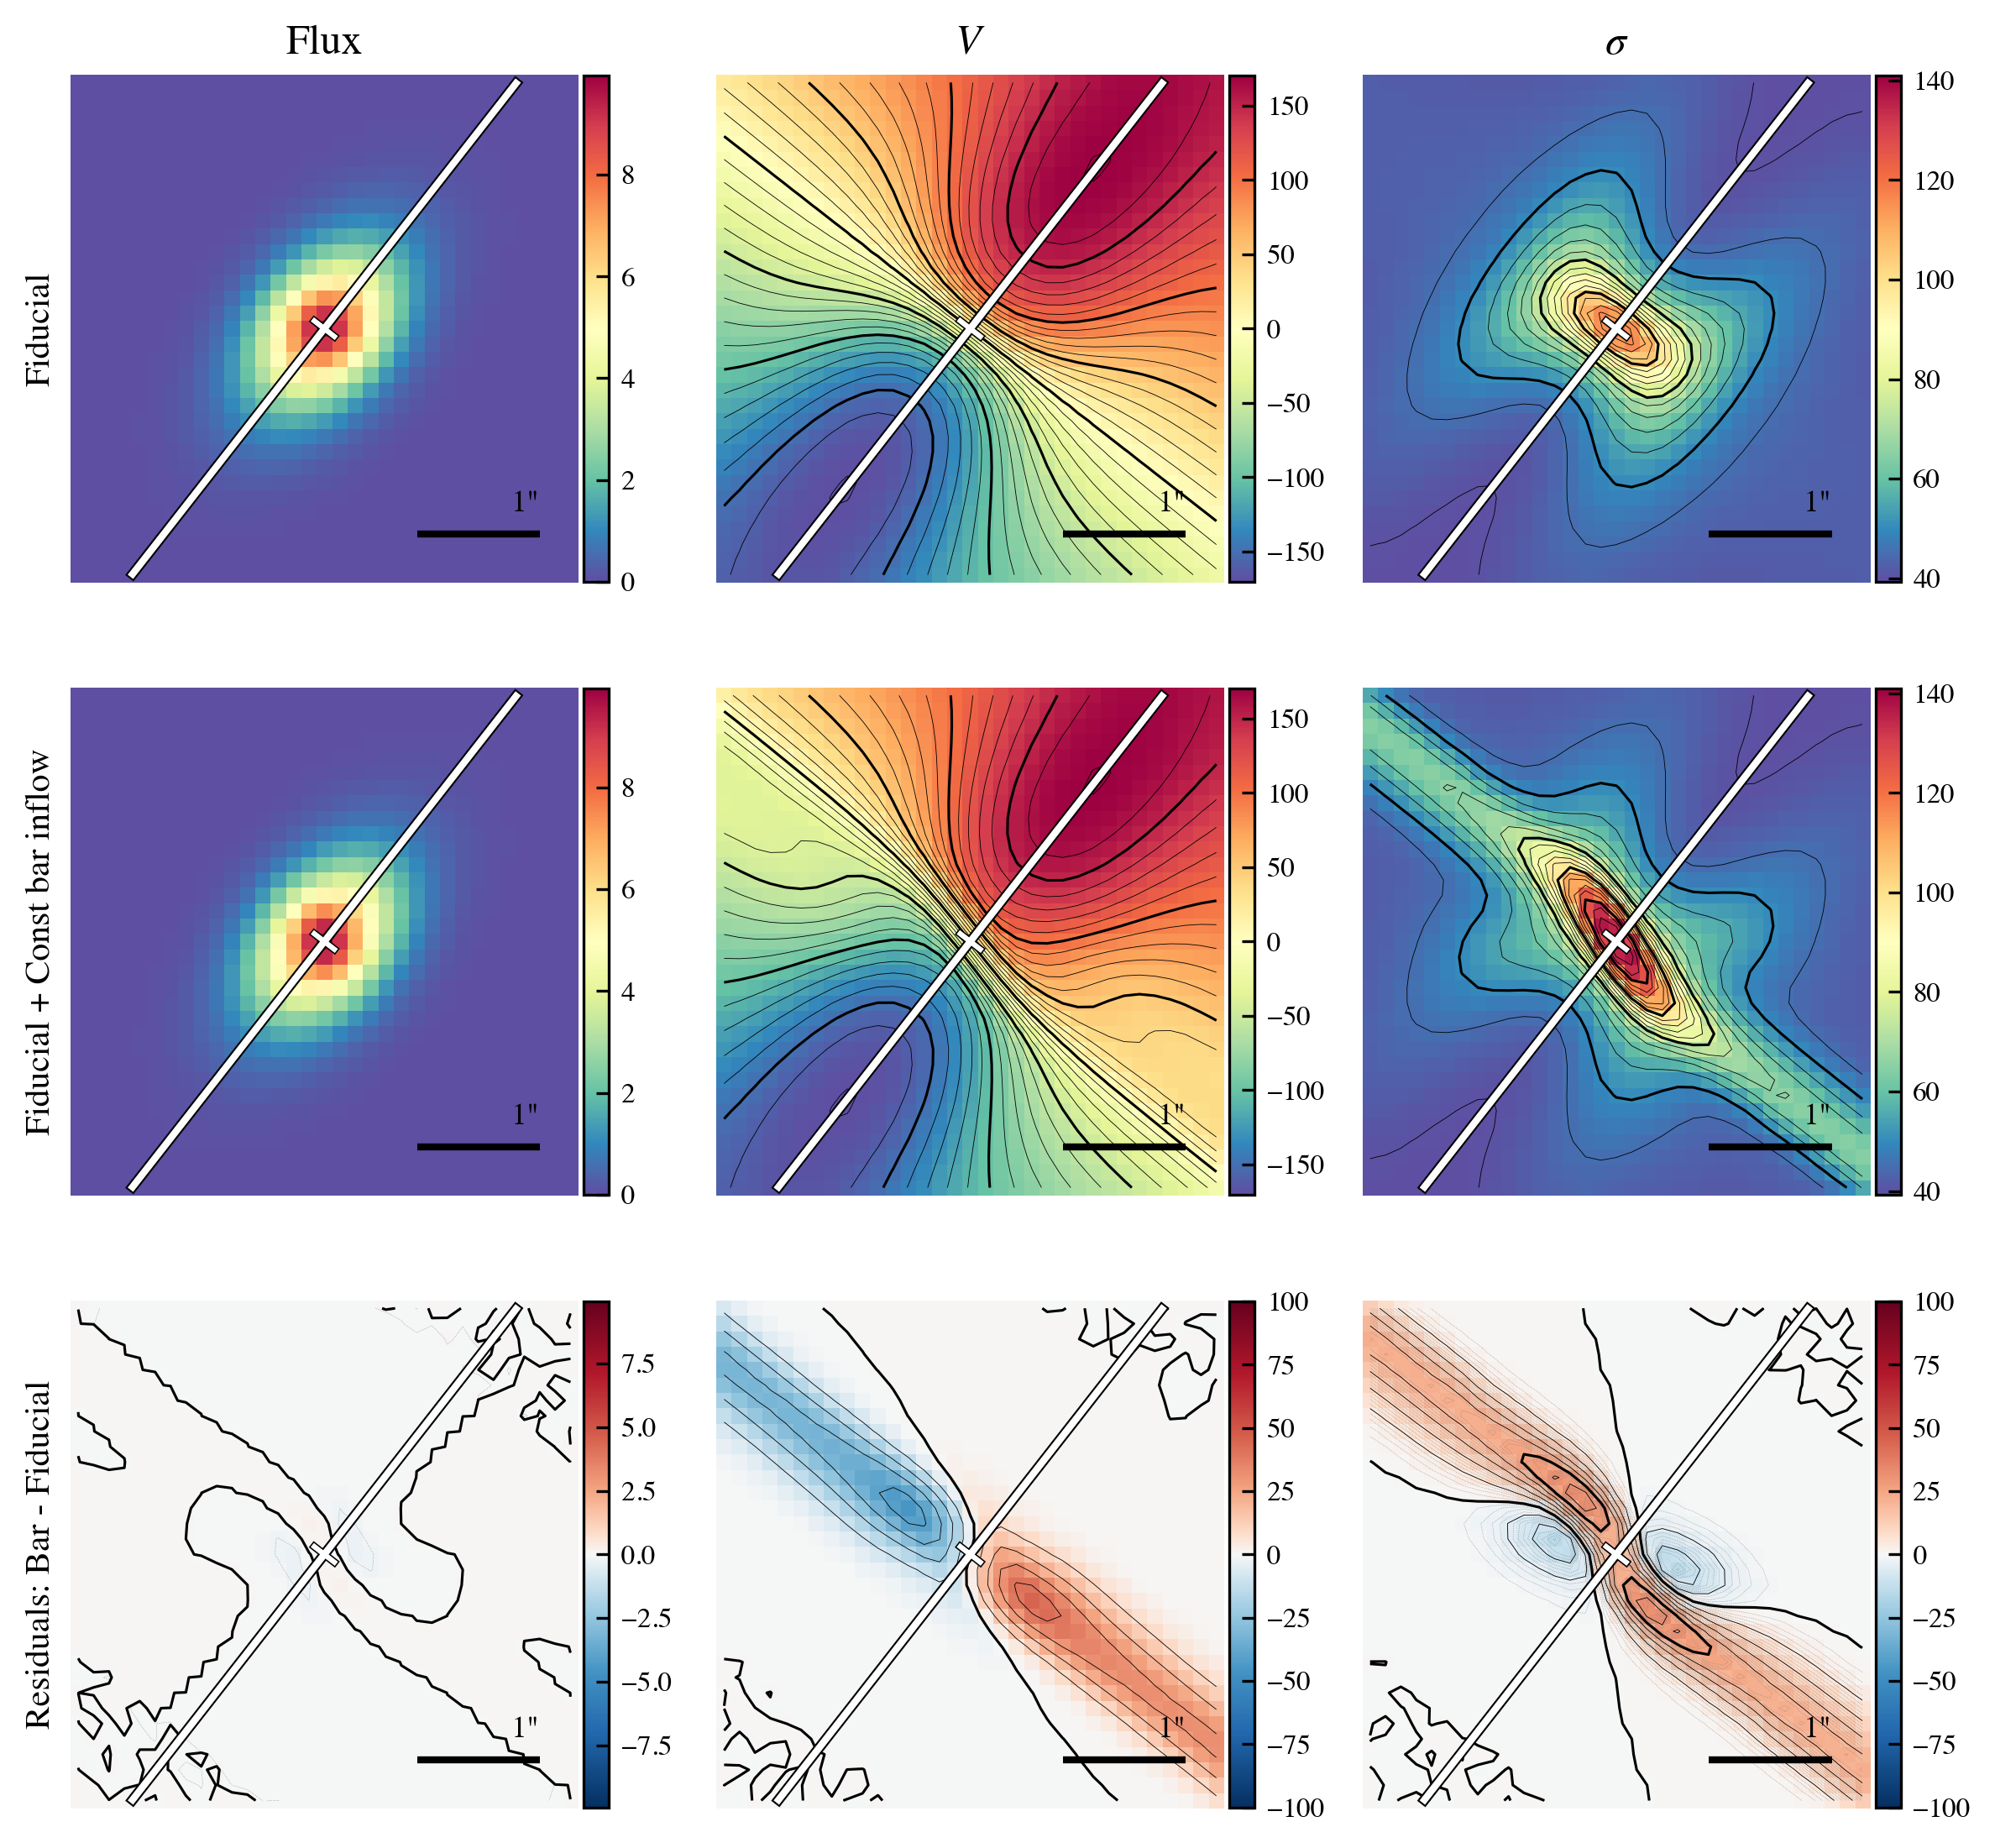

In [23]:
plotting.plot_model_comparison_2D(obs1=gal.observations['mock'], 
                                  obs2=gal_bar.observations['mock'], 
                                  model1=gal.model, model2=gal_bar.model,
                                  label_gal1='Fiducial', 
                                  label_gal2='Fiducial + Const bar inflow', 
                                  label_residuals='Residuals: Bar - Fiducial', 
                                  show_contours=True, **kwargs_contour)

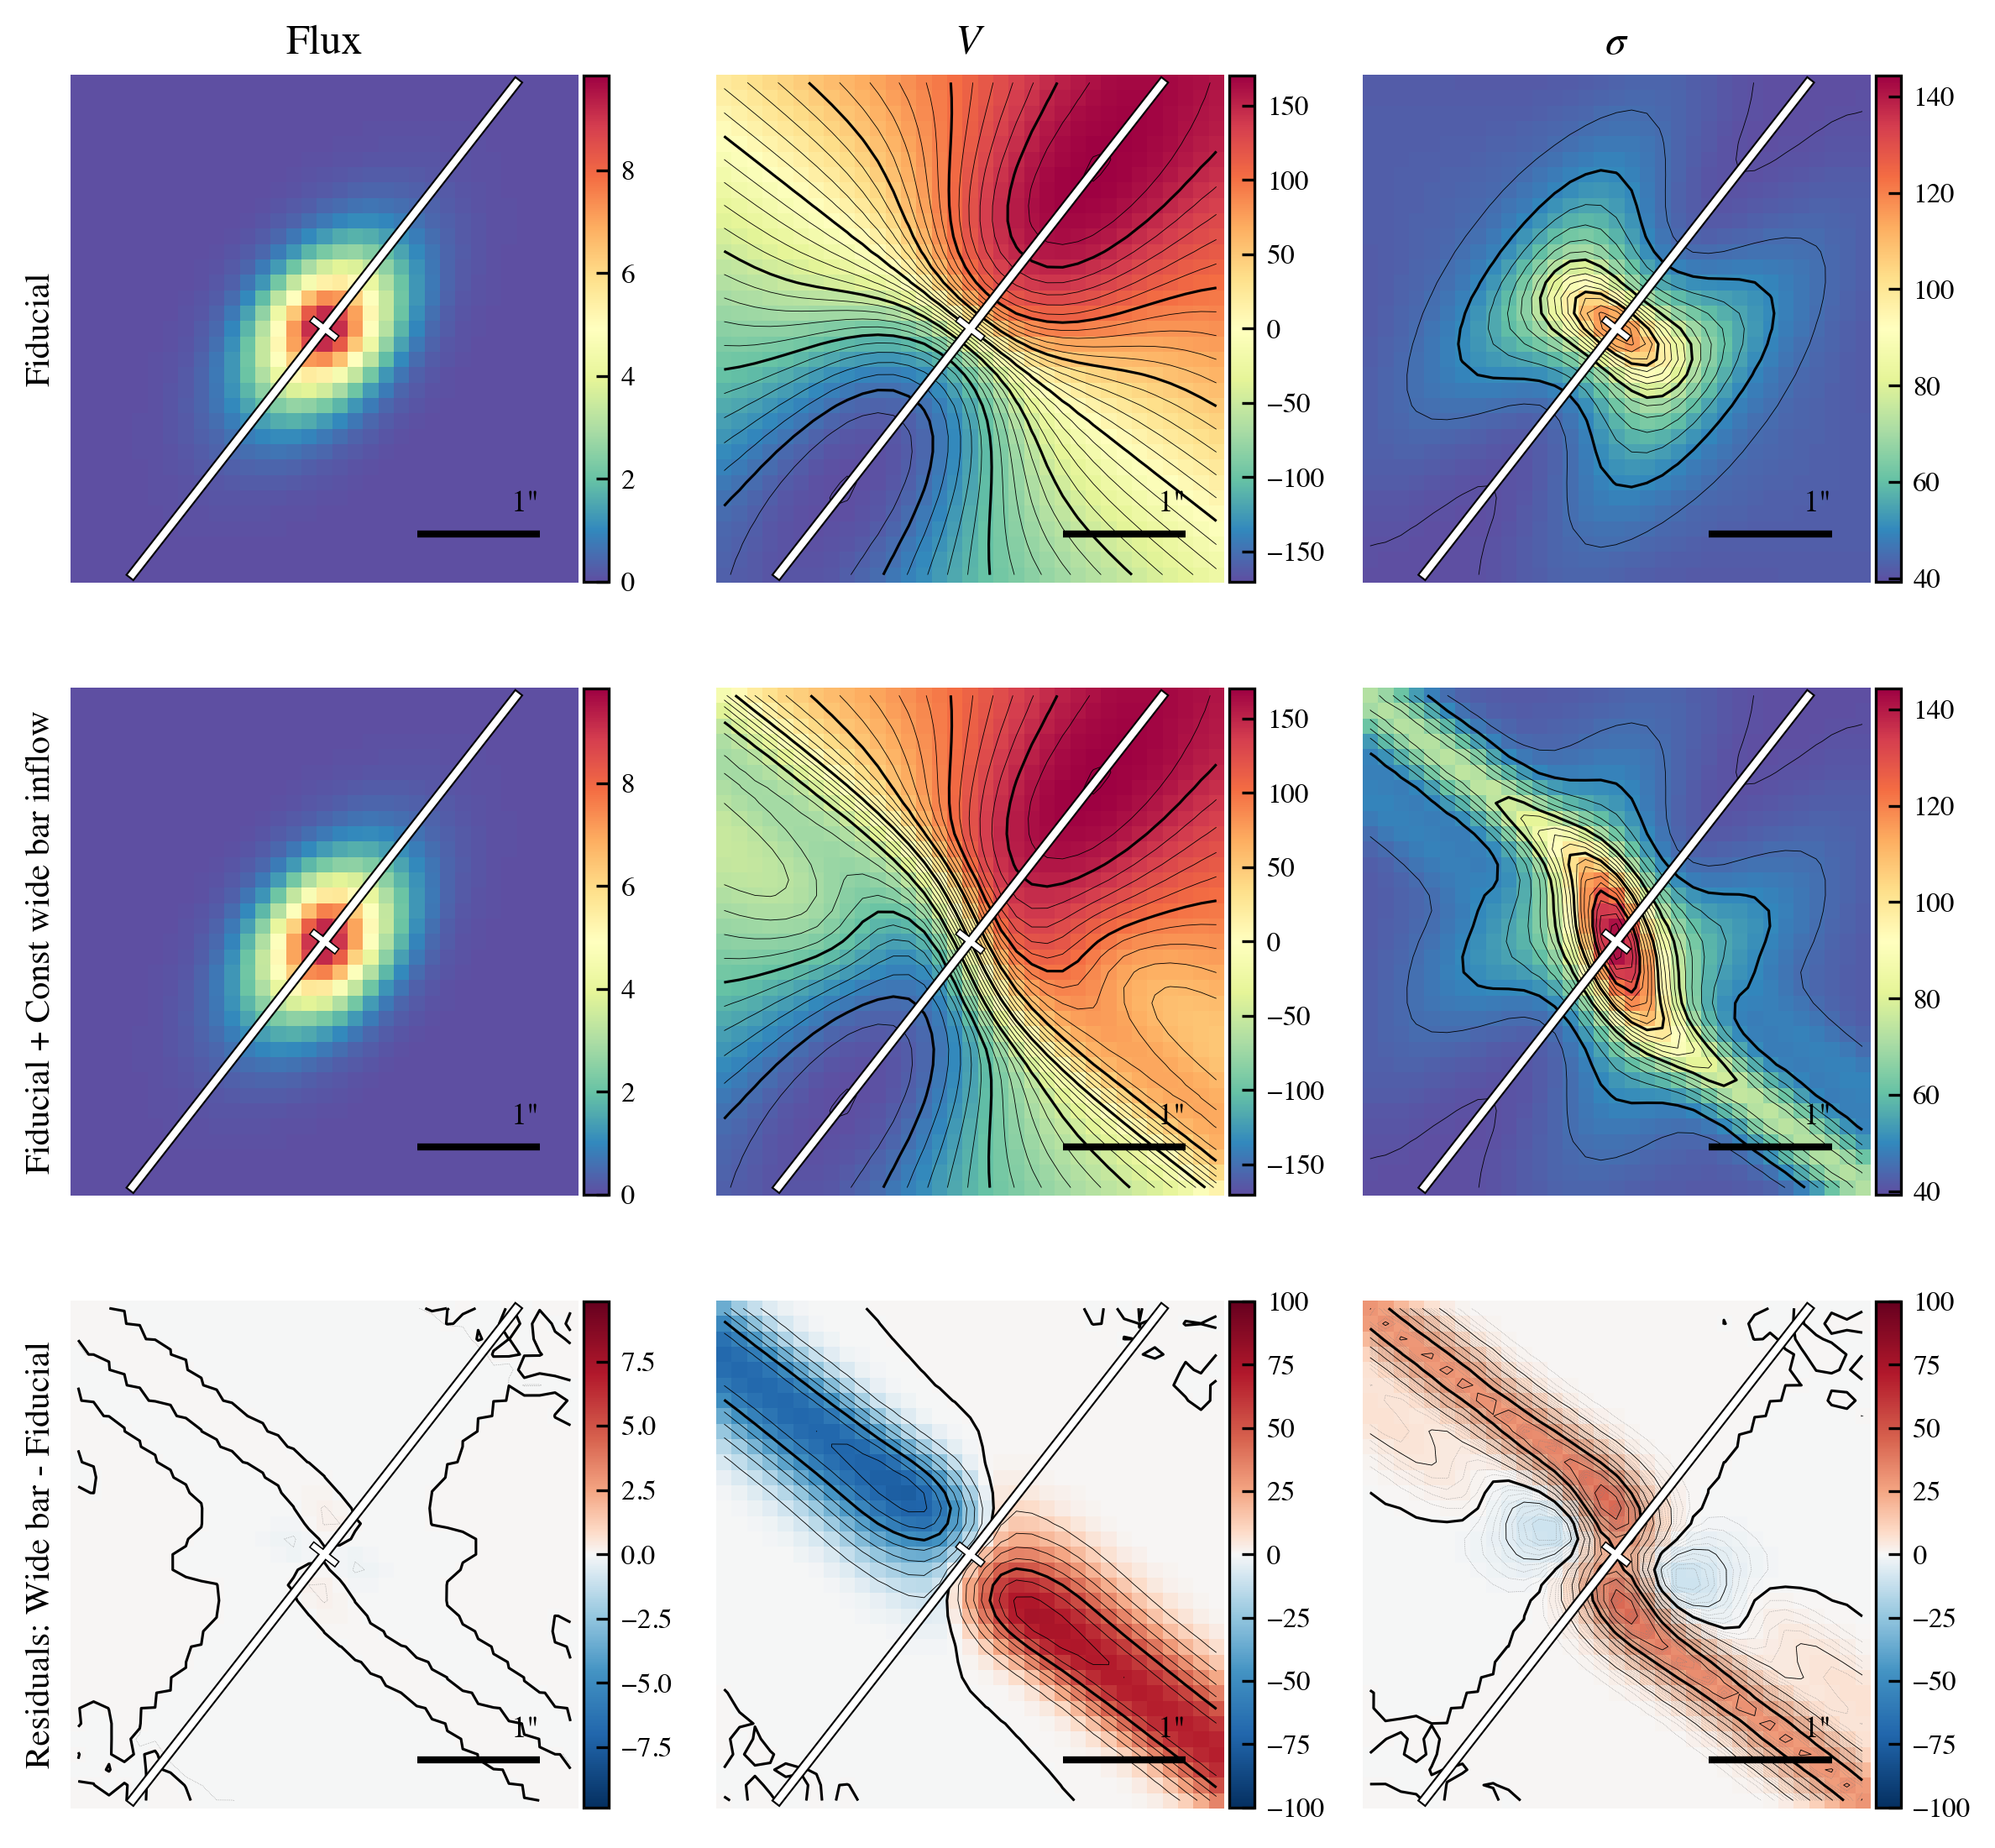

In [24]:
plotting.plot_model_comparison_2D(obs1=gal.observations['mock'], 
                                  obs2=gal_wide_bar.observations['mock'], 
                                  model1=gal.model, model2=gal_wide_bar.model,
                                  label_gal1='Fiducial', 
                                  label_gal2='Fiducial + Const wide bar inflow', 
                                  label_residuals='Residuals: Wide bar - Fiducial', 
                                  show_contours=True, **kwargs_contour)

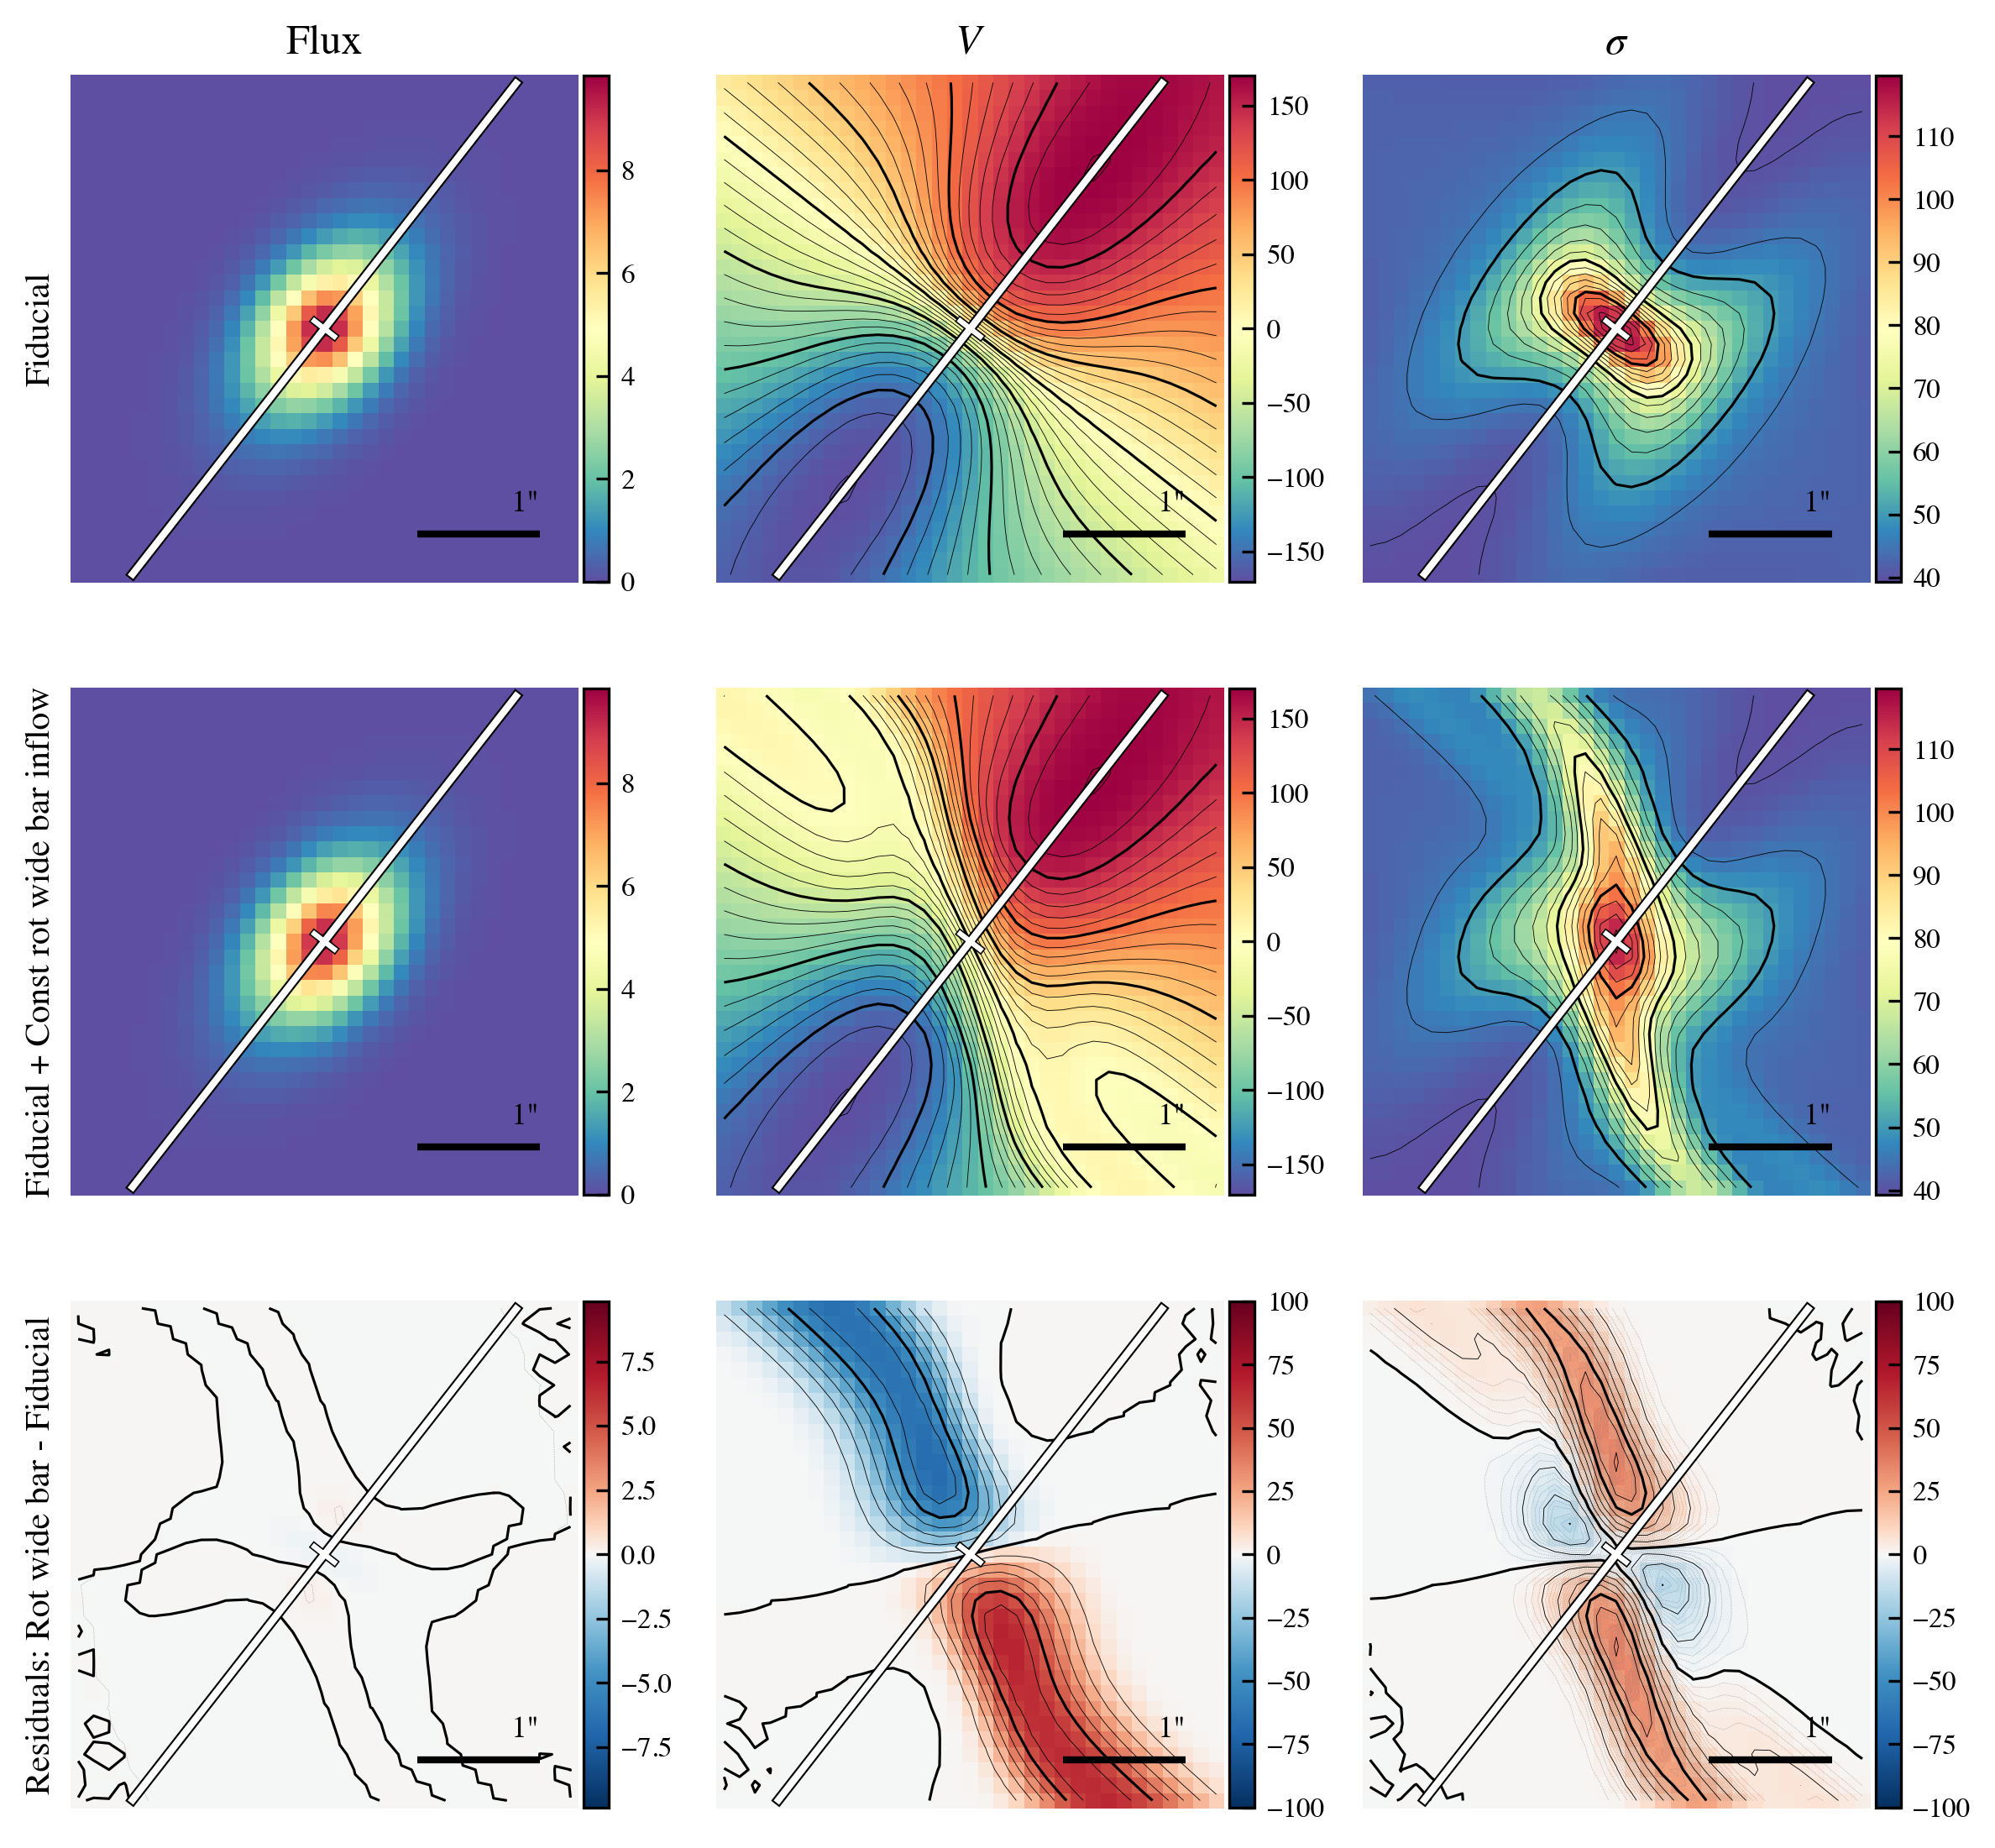

In [25]:
plotting.plot_model_comparison_2D(obs1=gal.observations['mock'], 
                                  obs2=gal_wide_bar_rot.observations['mock'],  
                                  model1=gal.model, model2=gal_wide_bar_rot.model,
                                  label_gal1='Fiducial', 
                                  label_gal2='Fiducial + Const rot wide bar inflow', 
                                  label_residuals='Residuals: Rot wide bar - Fiducial', 
                                  show_contours=True, **kwargs_contour)